In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from environs import Env
env = Env()
env.read_env()
api_key=env("BITMEX_API_KEY")
api_secret=env("BITMEX_API_SECRET")

In [3]:
# Setup matplotlib to display graphs inline in this Notebook
%matplotlib inline

In [4]:
import bitmex
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from time import sleep
from scipy.signal import argrelextrema
from utils import get_klines_df, get_instrument
pd.set_option('display.width', 200)

/home/chekitsch/miniconda3/lib/python3.7/site-packages/swagger_spec_validator/validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


In [9]:
def turtle_soup(symbol, binSize, startDate, HOLDING_PERIOD, LOOKBACK_PERIOD = 120, ENTRY_BUFFER = 0.0020, STOP_LOSS_PCT_FLOOR=0.0015):
    '''
    symbol 'XBTUSD' 'ETHUSD'
    binSize ['1H', '2H', '4H'] etc... 
    startDate '2019-05-01'
    HOLDING_PERIOD
    LOOKBACK_PERIOD: for finding previous breakouts
    ENTRY_BUFFER
    '''
    
    data_df = get_klines_df(symbol, '1h', startDate)
    data_df = data_df.drop(columns=['homeNotional','foreignNotional','turnover','vwap','lastSize'])
    data_df = data_df.drop([0], axis=0)    # drop first row, otherwise resample will not work properly
    data_df.index = data_df.timestamp     # change RangeIndex to TimestampIndex
    
    tickSize = get_instrument(symbol)['tickSize']
    BREAKOUT_X_PERIOD = 19
    
    # resample to X-hour candle
    TD_binSize = timedelta(hours = int(binSize[:-1]))
    data_df = data_df.resample(binSize, closed='right').apply({'symbol':'first', 'open':'first', 'high':'max', 'low':'min', 'close':'last', 'trades':'sum', 'volume':'sum'})
    
    data_df['period_high_slow'] = data_df['high'].rolling(BREAKOUT_X_PERIOD, min_periods=4).max().shift(1)
    data_df['period_high_fast'] = data_df['high'].rolling(3, min_periods=3).max().shift(1)

    data_df['period_low_slow'] = data_df['low'].rolling(BREAKOUT_X_PERIOD, min_periods=4).min().shift(1)
    data_df['period_low_fast'] = data_df['low'].rolling(3, min_periods=3).min().shift(1)
    
    # assign new columns based on conditions
    data_df.loc[data_df.high > data_df.period_high_slow, 'isNewHigh'] = True
    data_df.loc[data_df.high <= data_df.period_high_slow, 'isNewHigh'] = False

    data_df.loc[data_df.low < data_df.period_low_slow, 'isNewLow'] = True
    data_df.loc[data_df.low >= data_df.period_low_slow, 'isNewLow'] = False
    
    
    # find all local peaks and troughs
    n=4
    data_df['trough'] = data_df.iloc[argrelextrema(data_df.low.values, np.less_equal, order=n)[0]]['low']
    data_df['peak'] = data_df.iloc[argrelextrema(data_df.high.values, np.greater_equal, order=n)[0]]['high']

    # *****************************************
    #  generate transactions table (dataframe)
    # *****************************************
    i = 0
    # order_table = dict()    # symbol as key, include 'timestamp', side', 'reference peak/trough', 'entry_price', 'stop_price' and 'stop_loss'
    tx_df = pd.DataFrame(columns=['timestamp', 'side', 'ref_prices'])
    tx_df2 = pd.DataFrame(columns=['entry_time', 'exit_time', 'side', 'ref_price', 'entry_price', 'stop_loss', 'stop_loss_pct', 'high_water_mark', 'low_water_mark', 'max_abs_return', 'min_abs_return', 'stop_loss_triggered', 'whipsaw'])
    
    open_position = False

    for timestamp, row in data_df.iterrows():
        index = (timestamp - data_df.index[0]) / TD_binSize
        if index < LOOKBACK_PERIOD:
            continue
        start = timestamp - (LOOKBACK_PERIOD * TD_binSize)
        end = timestamp - (1 * TD_binSize)
        current_window = data_df.loc[start:end]    # exclude current value

        isNewLow_index = current_window[(current_window.isNewLow == True) & (current_window.trough > 0)].index
        local_troughs = current_window.low.loc[isNewLow_index]

        isNewHigh_index = current_window[(current_window.isNewHigh == True) & (current_window.peak > 0)].index
        local_peaks = current_window.high.loc[isNewHigh_index]
        # print('{timestamp} low: {low:6.2f}\thigh: {high:6.2f}\tclose: {close:6.2f}\t4-day high: {period_high_fast:6.2f}\n'.format(
        #    timestamp=timestamp, low=row.low, high=row.high, close=row.close, period_high_fast=row.period_high_fast
        # ))

        if len(local_troughs) > 0:
            ref_prices = []
            for idx in local_troughs.index:
                window = local_troughs[idx:local_troughs.index[len(local_troughs)-1]]
                abs_min = window.min()
                abs_min_idx = window.idxmin()
                # if not lowest trough and occurs prior to lowest trough, ignore it
                if window[idx] > abs_min and idx < abs_min_idx:
                    continue
                # make sure is 20-day low, AND previous low is at least 4 days earlier
                elif row.low < row.period_low_slow and row.period_low_fast > window[idx]:
                    if row.low < window[idx]:    # break previous troughs, potential trade entry, saved for further processing
                        ref_prices.append(window[idx])
            if len(ref_prices)>0:
                tx_df.loc[len(tx_df)] = [timestamp, 'BUY', tuple(ref_prices)]

        if len(local_peaks) > 0:
            ref_prices = []
            for idx in local_peaks.index:
                window = local_peaks[idx:local_peaks.index[len(local_peaks)-1]]
                abs_max = window.max()
                abs_max_idx = window.idxmax()
                # if not highest peak and occurs prior to highest peak, ignore it
                if window[idx] < abs_max and idx < abs_max_idx:
                    continue
                # make sure is 20-day high, AND previous high is at least 4 days earlier
                elif row.high > row.period_high_slow and row.period_high_fast < window[idx]:
                    if row.high > window[idx]:    # break previous peaks, potential trade entry, saved for further processing
                        ref_prices.append(window[idx])
            if len(ref_prices)>0:
                tx_df.loc[len(tx_df)] = [timestamp, 'SELL', tuple(ref_prices)]
    # ********** END of data_df FOR loop **********


    # set timestamp as transaction dataframe index
    tx_df.set_index('timestamp', drop=True, inplace=True)
    time_checkpoint = datetime.now()
    
    
    # **********************************************
    #  enhance transaction table data ()
    # **********************************************
    for i,txn in tx_df.iterrows():
        start = (i + timedelta(minutes = 1)).strftime('%Y-%m-%d %H:%M:%S')
        end = (i + timedelta(minutes = 480)).strftime('%Y-%m-%d %H:%M:%S')

        # calculate time to sleep (60 requests per minute limit)
#         seconds_elapsed = (datetime.now() - time_checkpoint).microseconds / 1000000
#         seconds_to_sleep = max(0, 0.7 - seconds_elapsed)
        
        zoom_in_df = get_klines_df(symbol, '1m', start, end)
#         time_checkpoint = datetime.now()
#         print('seconds_to_sleep', seconds_to_sleep)
        sleep(0.60)
        
        zoom_in_df = zoom_in_df.drop(columns=['homeNotional','foreignNotional','turnover','vwap','lastSize'])
        zoom_in_df.index = zoom_in_df.timestamp     # change RangeIndex to TimestampIndex
        zoom_in_df = zoom_in_df.resample('1T', closed='right').apply({'symbol':'first', 'open':'first', 'high':'max', 'low':'min', 'close':'last', 'trades':'sum', 'volume':'sum'})
        open_position = False
        current_high = None
        current_low = None
        entry_price = None
        stop_loss_pct = None
        
        high_water_mark = None    # highest observed price, regardless of BUY SELL
        low_water_mark = None     # lowest observed price, regardless of BUY SELL
        stop_loss_triggered = False
        
        if txn.side == 'BUY':
            reference_trough = None
            for timestamp, data_bin in zoom_in_df.iterrows():
                if current_high is None or current_high < data_bin.high: # new high is made
                    current_high = data_bin.high
                if current_low is None or current_low > data_bin.low:    # new low is made
                    current_low = data_bin.low
                    for ref_trough in txn.ref_prices:    # iterate through previous troughs
                        if current_low < ref_trough:
                            reference_trough = ref_trough
                            # >>>>>>>>>>>>> ENTRY_PRICE, add buffer later <<<<<<<<<<<<
                            entry_price_raw = reference_trough * (1 + ENTRY_BUFFER)
                            stop_loss_pct = -abs(( current_low / entry_price_raw ) - 1)
                            # adjust entry price if stop_loss_pct below STOP_LOSS_PCT_FLOOR
                            if abs(stop_loss_pct) < STOP_LOSS_PCT_FLOOR:
                                entry_price_raw = current_low / (1-STOP_LOSS_PCT_FLOOR)
                                stop_loss_pct = -abs(( current_low / entry_price_raw ) - 1)
                            entry_price = math.floor(entry_price_raw/tickSize) * tickSize
                            break
                    if open_position:    # stop loss triggered, close position
                        tx_df2.loc[len(tx_df2)-1, 'exit_time'] = timestamp
                        tx_df2.loc[len(tx_df2)-1, 'high_water_mark'] = current_high
                        tx_df2.loc[len(tx_df2)-1, 'low_water_mark'] = tx_df2.loc[len(tx_df2)-1, 'stop_loss']
                        tx_df2.loc[len(tx_df2)-1, 'min_abs_return'] = ((tx_df2.loc[len(tx_df2)-1, 'low_water_mark']/tx_df2.loc[len(tx_df2)-1, 'entry_price']) - 1)
                        tx_df2.loc[len(tx_df2)-1, 'max_abs_return'] = ((tx_df2.loc[len(tx_df2)-1, 'high_water_mark']/tx_df2.loc[len(tx_df2)-1, 'entry_price']) - 1)
                        tx_df2.loc[len(tx_df2)-1, 'stop_loss_triggered'] = True
                        tx_df2.loc[len(tx_df2)-1, 'whipsaw'] = True
                        print(timestamp, 'same bar (1h) stop loss triggered')
                        current_low = None
                        stop_loss_pct = None
                        open_position = False
                if reference_trough is not None and data_bin.close > entry_price and not open_position:    # open position
                    if current_low is None: current_low = data_bin.low
                    if stop_loss_pct is None: stop_loss_pct = -abs(( current_low / entry_price_raw ) - 1)
                    current_high = None
                    tx_df2.loc[len(tx_df2)] = [timestamp, None, 'BUY', reference_trough, entry_price, current_low, stop_loss_pct, None, None, None, None, False, None]
                    open_position = True
            if len(tx_df2) > 0:
                if tx_df2.loc[len(tx_df2)-1, 'high_water_mark'] is None: 
                    tx_df2.loc[len(tx_df2)-1, 'high_water_mark'] = current_high
                if tx_df2.loc[len(tx_df2)-1, 'whipsaw'] is None: tx_df2.loc[len(tx_df2)-1, 'whipsaw'] = False
            
        if txn.side == 'SELL':
            reference_peak = None
            for timestamp, data_bin in zoom_in_df.iterrows():
                if current_low is None or current_low > data_bin.low:    # new low is made
                    current_low = data_bin.low
                if current_high is None or current_high < data_bin.high: # new high is made
                    current_high = data_bin.high
                    for ref_peak in txn.ref_prices:     # iterate through previous peaks
                        if current_high > ref_peak:
                            reference_peak = ref_peak
                            # >>>>>>>>>>>>> ENTRY_PRICE, add buffer later <<<<<<<<<<<<
                            entry_price_raw = reference_peak * (1 - ENTRY_BUFFER)
                            stop_loss_pct = -abs(( current_high / entry_price_raw ) - 1)
                            # adjust entry price if stop_loss_pct below STOP_LOSS_PCT_FLOOR
                            if abs(stop_loss_pct) < STOP_LOSS_PCT_FLOOR:
                                entry_price_raw = current_high / (1+STOP_LOSS_PCT_FLOOR)
                                stop_loss_pct = -abs(( current_high / entry_price_raw ) - 1)
                            entry_price = math.ceil(entry_price_raw/tickSize) * tickSize
                            break
                    if open_position:    # stop loss triggered, close position
                        tx_df2.loc[len(tx_df2)-1, 'exit_time'] = timestamp
                        tx_df2.loc[len(tx_df2)-1, 'low_water_mark'] = current_low
                        tx_df2.loc[len(tx_df2)-1, 'high_water_mark'] = tx_df2.loc[len(tx_df2)-1, 'stop_loss']
                        tx_df2.loc[len(tx_df2)-1, 'min_abs_return'] = ((tx_df2.loc[len(tx_df2)-1, 'high_water_mark']/tx_df2.loc[len(tx_df2)-1, 'entry_price']) - 1) * -1
                        tx_df2.loc[len(tx_df2)-1, 'max_abs_return'] = ((tx_df2.loc[len(tx_df2)-1, 'low_water_mark']/tx_df2.loc[len(tx_df2)-1, 'entry_price']) - 1) * -1
                        tx_df2.loc[len(tx_df2)-1, 'stop_loss_triggered'] = True
                        tx_df2.loc[len(tx_df2)-1, 'whipsaw'] = True
                        print('same bar (1h) stop loss triggered')
                        current_high = None
                        stop_loss_pct = None
                        open_position = False
                if reference_peak is not None and data_bin.close < entry_price and not open_position:    # open position
                    if current_high is None: current_high = data_bin.high
                    if stop_loss_pct is None: stop_loss_pct = -abs(( current_high / entry_price_raw ) - 1)
                    current_low = None
                    tx_df2.loc[len(tx_df2)]= [timestamp, None, 'SELL', reference_peak, entry_price, current_high, stop_loss_pct, None, None, None, None, False, None]
                    open_position = True
            if len(tx_df2) > 0:
                if tx_df2.loc[len(tx_df2)-1, 'low_water_mark'] is None: 
                    tx_df2.loc[len(tx_df2)-1, 'low_water_mark'] = current_low
                if tx_df2.loc[len(tx_df2)-1, 'whipsaw'] is None: tx_df2.loc[len(tx_df2)-1, 'whipsaw'] = False
    # ********** END of tx_df FOR loop **********
    
    
    # set timestamp as transaction dataframe index
    tx_df2.set_index('entry_time', drop=True, inplace=True)
    
    for i,txn in tx_df2.iterrows():
        
        high_water_mark = txn.high_water_mark    # highest observed price, regardless of BUY SELL
        low_water_mark = txn.low_water_mark     # lowest observed price, regardless of BUY SELL
        stop_loss_triggered = False
        
        if not txn['stop_loss_triggered']:
            trade_window = data_df.loc[i + TD_binSize : i + (TD_binSize * HOLDING_PERIOD)]
            for j,window in trade_window.iterrows():
                if txn.side == 'BUY' and window.low < txn.stop_loss and not stop_loss_triggered:
                    # BUY stoploss triggered
                    if high_water_mark is None or window.high > high_water_mark: high_water_mark = window.high
                    low_water_mark = txn.stop_loss
                    stop_loss_triggered = True
                    tx_df2.loc[i, 'exit_time'] = j
                    break
                if txn.side == 'SELL' and window.high > txn.stop_loss and not stop_loss_triggered:
                    # SELL stoploss triggered
                    if low_water_mark is None or window.low < low_water_mark: low_water_mark = window.low
                    high_water_mark = txn.stop_loss
                    stop_loss_triggered = True
                    tx_df2.loc[i, 'exit_time'] = j
                    break
                if high_water_mark is None or window.high > high_water_mark:
                    # if not yet stopped out, update high water mark as appropriate
                    high_water_mark = window.high
                if low_water_mark is None or window.low < low_water_mark:
                    # if not yet stopped out, update low water mark as appropriate
                    low_water_mark = window.low
            
            if tx_df2.loc[i, 'exit_time'] is None: 
                tx_df2.loc[i, 'exit_time'] = trade_window.index[-1]

            if txn.side == 'BUY':
                max_abs_return = ((high_water_mark/txn.entry_price) - 1)
                min_abs_return = ((low_water_mark/txn.entry_price) - 1)
            if txn.side == 'SELL':
                max_abs_return = ((low_water_mark/txn.entry_price) - 1) * -1
                min_abs_return = ((high_water_mark/txn.entry_price) - 1) * -1

            tx_df2.loc[i, 'high_water_mark'] = high_water_mark
            tx_df2.loc[i, 'low_water_mark'] = low_water_mark
            tx_df2.loc[i, 'max_abs_return'] = max_abs_return
            tx_df2.loc[i, 'min_abs_return'] = min_abs_return
            tx_df2.loc[i, 'stop_loss_triggered'] = stop_loss_triggered

            

#     # calculate risk-reward ratop
    tx_df2['rr_ratio'] = -(tx_df2.max_abs_return / tx_df2.stop_loss_pct)
    
    return (tx_df, tx_df2)

In [14]:
result, result2 = turtle_soup(symbol='XBTUSD', binSize='4H', startDate='2019-01-01 00:00:00', HOLDING_PERIOD=35, LOOKBACK_PERIOD=300, ENTRY_BUFFER=0.0010, STOP_LOSS_PCT_FLOOR=0.0030)

RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
same bar (1h) stop loss triggered
same bar (1h) stop loss triggered
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 58
2019-03-25 18:59:00+00:00 same bar (1h) stop loss triggered
RateLimit-Remaining 59
same bar (1h) stop loss triggered
RateLimit-Remaining 59
same bar (1h) stop loss triggered
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
same bar (1h) stop loss triggered
same bar (1h) stop loss triggered
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
same bar (1h) stop loss triggered
RateLimit-Remaining 59
same bar (1h) stop loss triggered
RateLimit-Remaining 59
RateLimit-Remaining 59
RateLimit-Remaining 59
same bar (1h) stop loss triggered
RateLimit-Remaining 59
same bar (1h) stop loss triggered
RateLimit-Remaining 59
RateLimit-Remaining 59
Ra

In [15]:
result2
# result2[result2['whipsaw'] == True]

,exit_time,side,ref_price,entry_price,stop_loss,stop_loss_pct,high_water_mark,low_water_mark,max_abs_return,min_abs_return,stop_loss_triggered,whipsaw,rr_ratio
entry_time,,,,,,,,,,,,,
2019-02-21 06:01:00+00:00,2019-02-23 16:00:00+00:00,SELL,3972.0,3968.5,3995.0,-0.006797,3995,3863,0.0265844,-0.00667759,True,False,3.911
2019-02-23 17:09:00+00:00,2019-02-23 17:36:00+00:00,SELL,3995.0,3991.5,4029.5,-0.009645,4029.5,3951,0.0101466,-0.00952023,True,True,1.05195
2019-02-23 18:06:00+00:00,2019-02-23 20:32:00+00:00,SELL,4130.0,4120.0,4132.0,-0.003000,4132,4074,0.011165,-0.00291262,True,True,3.72168
2019-02-23 21:10:00+00:00,2019-02-24 04:00:00+00:00,SELL,4130.0,4126.0,4157.5,-0.007666,4157.5,4097,0.0070286,-0.00763451,True,False,0.916822
2019-02-27 20:37:00+00:00,2019-03-05 16:00:00+00:00,BUY,3702.0,3705.5,3640.0,-0.017730,3895,3669,0.0511402,-0.00985022,False,False,2.88439
2019-03-06 10:45:00+00:00,2019-03-08 04:00:00+00:00,SELL,3895.0,3889.5,3901.0,-0.003000,3901,3823,0.0170973,-0.00295668,True,False,5.6991
2019-03-08 06:26:00+00:00,2019-03-09 04:00:00+00:00,SELL,3901.0,3897.5,3913.5,-0.004209,3913.5,3742.5,0.0397691,-0.0041052,True,False,9.44967
2019-03-09 07:05:00+00:00,2019-03-09 12:00:00+00:00,SELL,3913.5,3910.0,3928.0,-0.004710,3928,3877,0.0084399,-0.00460358,True,False,1.79197
2019-03-20 22:36:00+00:00,2019-03-21 12:00:00+00:00,SELL,4038.0,4034.0,4048.5,-0.003604,4048.5,3914.5,0.0296232,-0.00359445,True,False,8.21976


In [16]:
subset = result2
# subset = result2[result2['whipsaw'] == False]

rr_ratio = [10,8,7,6,5.5,5,4.5,4,3.5,3,2.5,2,1.75,1.5,1.25,1.0,0.75,0.5]
stop_loss_slippage = 1.3

for rr in rr_ratio:
    wins = (len(subset[subset.rr_ratio >= rr])*rr)
    losses = (len(subset[subset.rr_ratio < rr])*stop_loss_slippage)
    ret = wins - losses
    print( '{reward:4.0f} {risk:4.0f} {rr:6.2f} {ret:7.2f} {robustness:6.2f}'.format(
        reward = len(subset[subset.rr_ratio >= rr]), 
        risk = len(subset[subset.rr_ratio < rr]), 
        rr = rr, 
        ret = ret,
        robustness = ret / wins
    ))



   4   53  10.00  -28.90  -0.72
   8   49   8.00    0.30   0.00
  10   47   7.00    8.90   0.13
  11   46   6.00    6.20   0.09
  13   44   5.50   14.30   0.20
  13   44   5.00    7.80   0.12
  14   43   4.50    7.10   0.11
  14   43   4.00    0.10   0.00
  17   40   3.50    7.50   0.13
  19   38   3.00    7.60   0.13
  21   36   2.50    5.70   0.11
  23   34   2.00    1.80   0.04
  28   29   1.75   11.30   0.23
  30   27   1.50    9.90   0.22
  30   27   1.25    2.40   0.06
  32   25   1.00   -0.50  -0.02
  39   18   0.75    5.85   0.20
  45   12   0.50    6.90   0.31


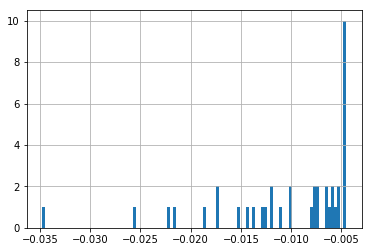

In [42]:
column = 'stop_loss_pct'
result.sort_values(by=[column])[column].hist(bins=100)

In [43]:
column = 'stop_loss_pct'
bins = np.arange(50) * 0.0025 - 0.10
result['binned'] = pd.cut(result[column], bins)
result.groupby(result['binned']).size()

binned
(-0.1, -0.0975]       0
(-0.0975, -0.095]     0
(-0.095, -0.0925]     0
(-0.0925, -0.09]      0
(-0.09, -0.0875]      0
(-0.0875, -0.085]     0
(-0.085, -0.0825]     0
(-0.0825, -0.08]      0
(-0.08, -0.0775]      0
(-0.0775, -0.075]     0
(-0.075, -0.0725]     0
(-0.0725, -0.07]      0
(-0.07, -0.0675]      0
(-0.0675, -0.065]     0
(-0.065, -0.0625]     0
(-0.0625, -0.06]      0
(-0.06, -0.0575]      0
(-0.0575, -0.055]     0
(-0.055, -0.0525]     0
(-0.0525, -0.05]      0
(-0.05, -0.0475]      0
(-0.0475, -0.045]     0
(-0.045, -0.0425]     0
(-0.0425, -0.04]      0
(-0.04, -0.0375]      0
(-0.0375, -0.035]     0
(-0.035, -0.0325]     1
(-0.0325, -0.03]      0
(-0.03, -0.0275]      0
(-0.0275, -0.025]     1
(-0.025, -0.0225]     0
(-0.0225, -0.02]      2
(-0.02, -0.0175]      1
(-0.0175, -0.015]     3
(-0.015, -0.0125]     3
(-0.0125, -0.01]      6
(-0.01, -0.0075]      3
(-0.0075, -0.005]    10
(-0.005, -0.0025]    10
(-0.0025, 0.0]        0
(0.0, 0.0025]         0
(0.0025, 

In [44]:
result[result.rr_ratio >= 2]['stop_loss_triggered'].value_counts()

False    11
True      8
Name: stop_loss_triggered, dtype: int64

In [45]:
column = 'stop_loss_pct'
result.sort_values(by=[column])

,side,entry_price,stop_loss,stop_loss_pct,high_water_mark,low_water_mark,max_abs_return,min_abs_return,stop_loss_triggered,rr_ratio,binned
timestamp,,,,,,,,,,,
2019-07-01 15:00:00+00:00,BUY,10308.7,9950.0,-0.034796,10658.5,9950.0,0.033933,-0.034796,True,0.975188,"(-0.035, -0.0325]"
2019-06-27 09:00:00+00:00,BUY,11642.7,11344.0,-0.025656,12177.5,11344.0,0.045934,-0.025656,True,1.790425,"(-0.0275, -0.025]"
2019-07-13 19:00:00+00:00,BUY,11194.4,10945.0,-0.022279,11182.5,10945.0,-0.001063,-0.022279,True,-0.047715,"(-0.0225, -0.02]"
2019-06-04 00:00:00+00:00,BUY,7889.9,7718.5,-0.021724,8020.0,7718.5,0.016489,-0.021724,True,0.759043,"(-0.0225, -0.02]"
2019-07-01 00:00:00+00:00,BUY,10813.6,10613.5,-0.018504,11220.0,10613.5,0.037582,-0.018504,True,2.030985,"(-0.02, -0.0175]"
2019-05-30 16:00:00+00:00,SELL,8956.3,9111.0,-0.017273,8673.5,7944.0,0.113027,0.031576,False,6.543633,"(-0.0175, -0.015]"
2019-06-15 16:00:00+00:00,SELL,8777.4,8929.0,-0.017272,8929.0,8775.0,0.000273,-0.017272,True,0.015831,"(-0.0175, -0.015]"
2019-07-01 13:00:00+00:00,BUY,10622.5,10459.0,-0.015392,10618.5,10459.0,-0.000377,-0.015392,True,-0.024465,"(-0.0175, -0.015]"
2019-07-14 09:00:00+00:00,BUY,10764.1,10610.0,-0.014316,10879.0,10610.0,0.010674,-0.014316,True,0.745620,"(-0.015, -0.0125]"


In [6]:
client = bitmex.bitmex(test=False, api_key=api_key, api_secret=api_secret)

In [7]:
sd = datetime.strptime('2019-05-13 03:00:00', '%Y-%m-%d %H:%M:%S')
ed = datetime.strptime('2019-05-18 03:00:00', '%Y-%m-%d %H:%M:%S')

In [8]:
for x in range(50):
    klines = client.Trade.Trade_getBucketed(symbol='XBTUSD', binSize='1h', startTime=sd, endTime=ed, count=500, partial=True).result()
    print('X-RateLimit-Remaining', klines[1].headers['X-RateLimit-Remaining'])
    sleep(0.70)

X-RateLimit-Remaining 59
X-RateLimit-Remaining 59
X-RateLimit-Remaining 59


In [13]:
time1 = datetime.now()

In [49]:
(datetime.now() - time1).microseconds

491931

In [21]:
client.Trade.Trade_getBucketed(symbol='XBTUSD', binSize='5m', startTime=datetime.strptime('2019-05-13 03:00:00', '%Y-%m-%d %H:%M:%S'), endTime=datetime.strptime('2019-05-13 11:00:00', '%Y-%m-%d %H:%M:%S'), count=5).result()

([{'timestamp': datetime.datetime(2019, 5, 13, 3, 0, tzinfo=tzutc()),
   'symbol': 'XBTUSD',
   'open': 7035.0,
   'high': 7047.0,
   'low': 7035.0,
   'close': 7044.5,
   'trades': 2055,
   'volume': 10490419,
   'vwap': 7043.2455,
   'lastSize': 1000,
   'turnover': 148943591797,
   'homeNotional': 1489.435917969999,
   'foreignNotional': 10490419.0},
  {'timestamp': datetime.datetime(2019, 5, 13, 3, 5, tzinfo=tzutc()),
   'symbol': 'XBTUSD',
   'open': 7044.5,
   'high': 7070.0,
   'low': 7031.5,
   'close': 7057.5,
   'trades': 4394,
   'volume': 18444734,
   'vwap': 7053.181,
   'lastSize': 250,
   'turnover': 261512720319,
   'homeNotional': 2615.12720319,
   'foreignNotional': 18444734.0},
  {'timestamp': datetime.datetime(2019, 5, 13, 3, 10, tzinfo=tzutc()),
   'symbol': 'XBTUSD',
   'open': 7057.5,
   'high': 7071.0,
   'low': 7054.5,
   'close': 7071.0,
   'trades': 2467,
   'volume': 10287383,
   'vwap': 7064.6415,
   'lastSize': 57,
   'turnover': 145626395895,
   'homeNoti

In [18]:
result_subset

NameError: name 'result_subset' is not defined

In [141]:
rr_ratio = [12,10,9,8,7,6.5,6,5.5,5,4.5,4,3.5,3,2.5,2,1.5,1.0]

In [145]:
12 in rr_ratio

True

In [321]:
TD_binSize = timedelta(hours = 1)
data_df = get_klines_df('XBTUSD', '1h', '2019-07-01 00:00:00')
data_df = data_df.drop(columns=['homeNotional','foreignNotional','turnover','vwap','lastSize'])
data_df = data_df.drop([0], axis=0)    # drop first row, otherwise resample will not work properly
data_df.index = data_df.timestamp     # change RangeIndex to TimestampIndex

data_df['period_high_slow'] = data_df['high'].rolling(19, min_periods=4).max().shift(1)
data_df['period_high_fast'] = data_df['high'].rolling(3, min_periods=3).max().shift(1)

data_df['period_low_slow'] = data_df['low'].rolling(19, min_periods=4).min().shift(1)
data_df['period_low_fast'] = data_df['low'].rolling(3, min_periods=3).min().shift(1)

# assign new columns based on conditions
data_df.loc[data_df.high > data_df.period_high_slow, 'isNewHigh'] = True
data_df.loc[data_df.high <= data_df.period_high_slow, 'isNewHigh'] = False

data_df.loc[data_df.low < data_df.period_low_slow, 'isNewLow'] = True
data_df.loc[data_df.low >= data_df.period_low_slow, 'isNewLow'] = False

In [248]:
for timestamp,row in data_df.iterrows():
    print(data_df.loc[timestamp-(3*TD_binSize):timestamp]['isNewLow'].value_counts())
    print(True in data_df.loc[timestamp-(3*TD_binSize):timestamp]['isNewLow'].value_counts().index)

Series([], Name: isNewLow, dtype: int64)
False
Series([], Name: isNewLow, dtype: int64)
False
Series([], Name: isNewLow, dtype: int64)
False
Series([], Name: isNewLow, dtype: int64)
False
False    1
Name: isNewLow, dtype: int64
False
False    2
Name: isNewLow, dtype: int64
False
False    3
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    4
Name: isNewLow, dtype: int64
False
False    3
True     1
Name: isNewLow, dtype: int64
True
False    3
True     1
Name: isNewLow, dtype: int64
True
True     2
False    2
Name: isNewLow, dtype: int64
True
True     3
False    1
Name: isNewLow, dtype: int64
True
True     2
False    2
Name: isNewLow, dtype: int64
True
True     2
False    2
Name: isNewLow, dtype: int64
True
False    3
True     1
Name: isNewLow, dtype: int64
True
False    4
Name: isNewLow, dtype: int64
False
False 

In [175]:
data_df.index[0]

Timestamp('2019-07-01 01:00:00+0000', tz='tzutc()')

In [329]:
data_df.loc[data_df.tail(4)['low'].idxmin()]

TypeError: Cannot index by location index with a non-integer key

In [356]:
tx_df = pd.DataFrame(columns=['timestamp', 'side', 'entry_price', 'stop_loss'])
len(tx_df)

0